# Claims made about poultry, pork, and beef.

Article [here](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P).

### “poultry costs U.S. consumers 62% less in inflation-adjusted terms than it did in 1935”

I'm going to go to FRED and get the price of Chicken, Fresh, Whole, Per Lb. (453.6 Gm) in U.S. City Average. [Here](https://fred.stlouisfed.org/series/APU0000706111#0) This way I can download the data in a nice clean format. 

Series ID APU0000706111

I'll need to adjust for inflation, so I'll use the CPI: [CPIAUCSL](https://fred.stlouisfed.org/series/CPIAUCSL).

**Also, I can't find where he got data going all the way back to the 30s??**

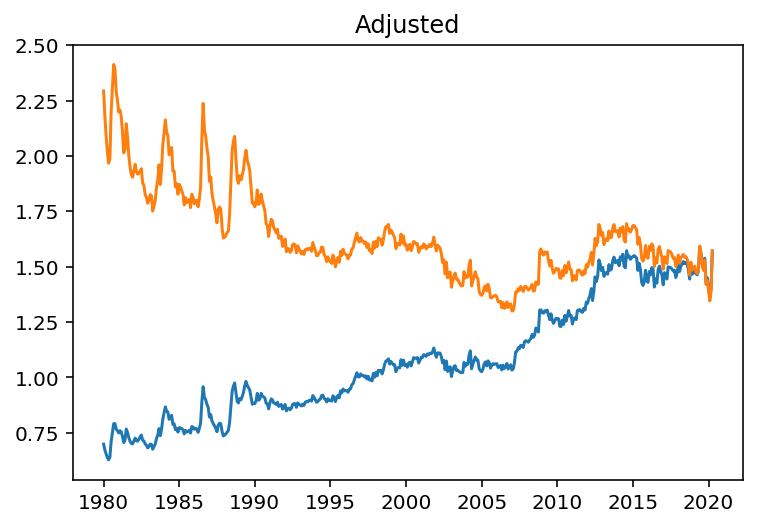

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

%config InlineBackend.figure_format = 'retina'

cpi = pd.read_csv('data/CPIAUCSL.csv')

# Get most recent cpi
most_recent = cpi.loc[cpi['DATE'] == cpi['DATE'].max(), 'CPIAUCSL'].values[0]

def get_adjust(past_cpi, current_cpi, past_price):
    """
    Return a past price adjusted for inflation
    """
    return (current_cpi / past_cpi) * past_price

df = (
    pd.read_csv('data/APU0000706111.csv')
    .rename(columns={'APU0000706111':'price'})
    .pipe(pd.merge, cpi, how='left', on='DATE')
)
df['DATE'] = pd.to_datetime(df['DATE'])
df['adjusted'] = df.apply(lambda x: get_adjust(past_cpi=x['CPIAUCSL'],
                                               current_cpi=most_recent,
                                               past_price=x['price']), axis=1)

plt.title('Unadjusted');
plt.plot(df['DATE'], df['price']);

plt.title('Adjusted');
plt.plot(df['DATE'], df['adjusted']);

### “Pork, now also raised mostly at factory scale indoors, is 12% cheaper”

### “Beef, which isn’t, costs 63% more. “